<a href="https://colab.research.google.com/github/AdrianUrbanski/ADM/blob/main/lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install tslearn

     |████████████████████████████████| 798kB 6.3MB/s 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import gzip
import pickle
from time import time
from tqdm.auto import tqdm

%matplotlib inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans

In [4]:
from itertools import zip_longest

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

# Assignment 1

## a)

In [5]:
def dtw_dist(a, b):
    return np.abs(a-b)

def euclidean_distance(a, b):
    return ((a-b)**2).sum()

def manhattan_distance(a, b):
    return np.abs(a-b).sum()

In [6]:
def dynamic_time_warping(s, t, distance=dtw_dist):
    n, m = s.shape[0], t.shape[0]
    DTW = np.zeros((n+1, m+1), dtype='float64') + np.infty
    prev = np.empty((n+1, m+1), dtype=object)

    DTW[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            for match in [(i-1, j), (i, j-1), (i-1, j-1)]:
                if DTW[i, j] > distance(s[i-1], t[j-1]) + DTW[match]:
                    DTW[i, j] = distance(s[i-1], t[j-1]) + DTW[match]
                    prev[i, j] = match

    current_match = (n, m)
    matches = []
    while current_match != (0, 0):
        matches.append((current_match[0]-1, current_match[1]-1))
        current_match = prev[current_match]

    return np.array(matches[::-1])

In [7]:
def calculate_distance(s, t, matches, dist=dtw_dist):
    distance = 0
    for match in matches:
        distance += dist(s[match[0]], t[match[1]])
    return distance

## b)

### linear

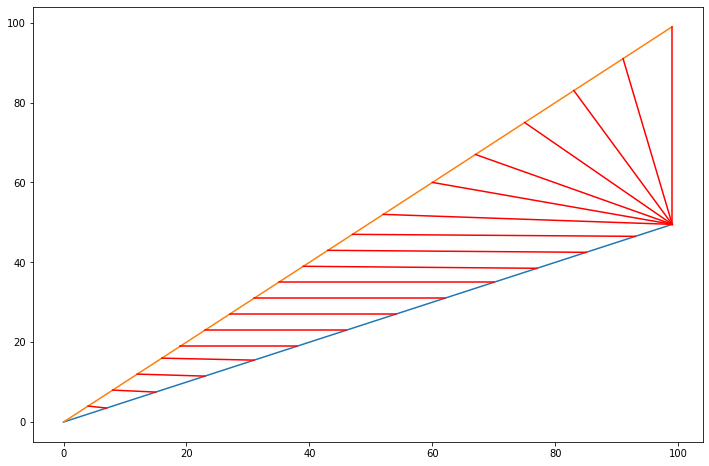

In [ ]:
s, t = np.arange(100)/2, np.arange(100)
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

### sin

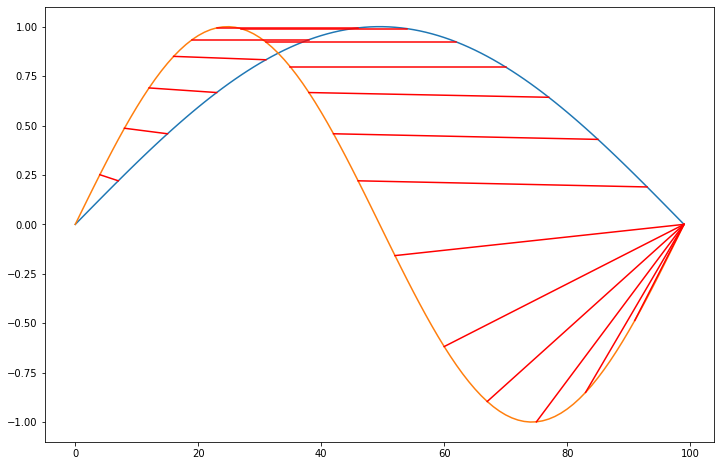

In [ ]:
s, t = np.sin(np.linspace(0, np.pi, num=100, endpoint=True)), np.sin(np.linspace(0, 2*np.pi, num=100, endpoint=True))
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

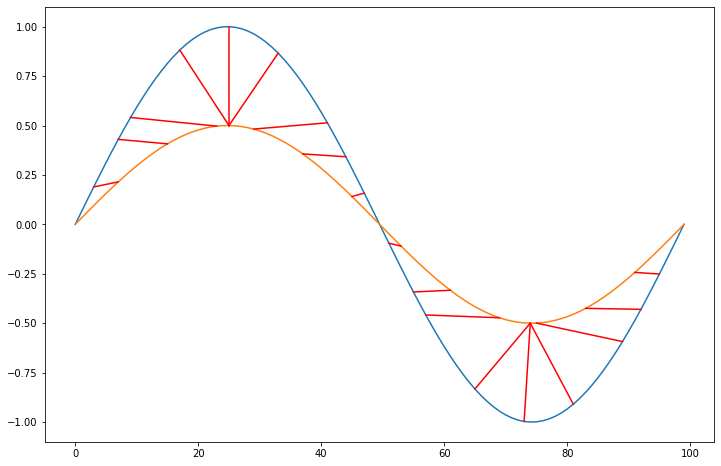

In [ ]:
s, t = np.sin(np.linspace(0, 2*np.pi, num=100, endpoint=True)), (1/2)*np.sin(np.linspace(0, 2*np.pi, num=100, endpoint=True))
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

### tanh

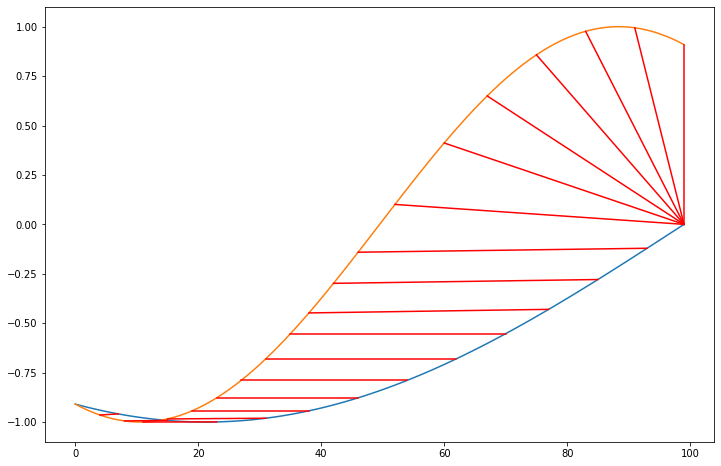

In [ ]:
s, t = np.sin(np.linspace(-2, 0, num=100, endpoint=True)), np.sin(np.linspace(-2, 2, num=100, endpoint=True))
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

## c)

In [8]:
def generate_time_series(starting_point=0, len=1000, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = starting_point
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [110]:
def make_random_copy(s, len=100):
    base_len = s.shape[0]
    a = np.floor(np.random.uniform(0, base_len-len))
    b = np.floor(np.random.uniform(a+len, base_len))
    return s[np.linspace(a, b, num=len, endpoint=True, dtype=int)].copy()

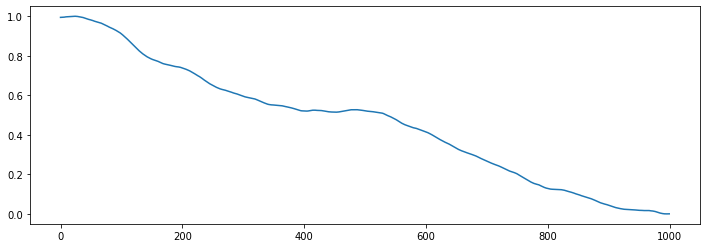

In [10]:
plt.figure(figsize=(12,4))
base_time_series = generate_time_series()
plt.plot(base_time_series)

(0.0, 1.0)

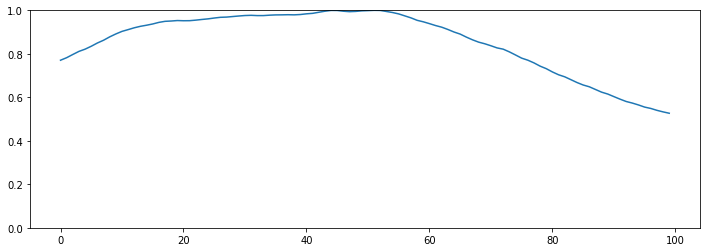

In [18]:
plt.figure(figsize=(12,4))
plt.plot(make_random_copy(base_time_series))
plt.ylim((0,1))

## d)

In [461]:
time_series_count = 10
copies_count = 10
len_base = 150
len_copy = 100
time_series = np.empty((time_series_count*copies_count, len_copy))
for ts_num in range(time_series_count):
    ts = generate_time_series(len=len_base)
    for cp_num in range(copies_count):
        time_series[ts_num*copies_count + cp_num, :] = make_random_copy(ts, len=len_copy)

In [469]:
t0 = time()
opt_distances = np.zeros((time_series_count*copies_count, time_series_count*copies_count))
for ts1 in tqdm(range(time_series_count*copies_count)):
    for ts2 in range(ts1, time_series_count*copies_count):
            opt_distances[ts1, ts2] = calculate_distance(time_series[ts1], time_series[ts2],
                                                         dynamic_time_warping(time_series[ts1], time_series[ts2]))

print(time() - t0)


638.1317694187164


In [470]:
opt_distances[:10, :10].mean()

1.638902873817184

In [473]:
opt_distances[:10, 10:20].mean()/2

24.956084480273653

In [474]:
with np.printoptions(threshold=np.inf, linewidth=150):
    print(opt_distances[0:30, 0:30].astype(int))


[[ 0  1  0  0 11  0  1  9  0  0 48 47 51 47 48 50 47 50 47 47  1  1  0  0 19  0  1  1  3  1]
 [ 0  0  1  1  4  1  0  3  1  1 54 48 56 53 52 53 51 55 49 50  1  1  1  1 10  1  0  0  1  1]
 [ 0  0  0  0  9  0  1  8  0  0 51 48 54 50 50 52 50 53 49 49  1  1  1  0 17  0  1  1  3  0]
 [ 0  0  0  0  9  0  1  8  0  0 50 47 53 49 49 51 48 52 48 48  1  1  0  0 17  0  1  1  3  0]
 [ 0  0  0  0  0 11  5  0 11 12 53 41 54 52 48 48 47 51 43 46  4  5  7  5  3  6  4  3  3  6]
 [ 0  0  0  0  0  0  1 10  0  0 49 48 53 48 49 51 49 52 48 49  2  1  0  1 20  0  1  1  4  0]
 [ 0  0  0  0  0  0  0  4  1  2 51 46 54 51 50 51 49 53 47 49  0  0  2  0 11  1  1  1  3  1]
 [ 0  0  0  0  0  0  0  0  9 10 53 42 54 52 49 49 47 52 44 46  3  4  6  5  3  5  3  3  3  5]
 [ 0  0  0  0  0  0  0  0  0  0 48 47 51 47 48 50 47 50 47 47  1  1  0  0 19  0  1  1  3  1]
 [ 0  0  0  0  0  0  0  0  0  0 48 47 52 47 48 51 48 51 48 48  2  1  0  1 20  0  1  2  3  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  1  0  0  2  1 53 54 54

In [463]:
t0 = time()
distances = np.zeros((time_series_count*copies_count, time_series_count*copies_count))
for ts1 in tqdm(range(time_series_count*copies_count)):
    for ts2 in range(ts1, time_series_count*copies_count):
            distances[ts1, ts2] = calculate_distance(time_series[ts1], 
                                                     time_series[ts2],
                                                     dynamic_time_warping_improved(time_series[ts1], time_series[ts2]))

print(time() - t0)


93.35738849639893


In [464]:
distances[:10, :10].mean()

10.497674418546335

In [468]:
distances[:10, 10:20].mean()/2

26.02004539981671

In [467]:
with np.printoptions(threshold=np.inf, linewidth=150):
    print(distances[0:30, 0:30].astype(int))


[[  0   3   1  91  15  18   2  12   0   0  48  47  51  47  48  50  47  50  47  47   6   4   2  10  35   1   4   7  15   4]
 [  0   0   1   3  44   8   1  23   4   2  61  54  64  60  59  60  58  63  56  57   3   3   3   3  12   2   2  10   4   3]
 [  0   0   0   3  11   1   1  13   1   1  51  48  54  50  50  52  50  53  49  49  23  71   3   2  38   3  23   7  15  88]
 [  0   0   0   0  11   1   3  14   0   0  50  47  53  49  49  51  49  52  48  48  22  69   6   2  45   8  21   5  16  14]
 [  0   0   0   0   0 130   5  54 127 131  59  47  61  59  54  55  53  58  49  52   9  42 115 101   4 111  11  16   5  16]
 [  0   0   0   0   0   0  13  11   1   1  49  48  53  48  49  51  49  52  49  49  62   5   2   9  41   2   3   3  22   9]
 [  0   0   0   0   0   0   0   5   2   3  51  46  54  51  50  52  49  53  47  49  26  82   6   4  25   4  90   3   9 101]
 [  0   0   0   0   0   0   0   0 127 131  59  47  61  59  55  56  54  59  49  53   5   6 115 101   6 111  39  16   6  30]
 [  0   0   0   

21 min dla 10 kopii, dla 100 ~33h

# Assignment 2

In [418]:
def dynamic_time_warping_improved(s, t, distance=dtw_dist, get_dist=False, gamma=1,
                                  rand='linspace', improve_matches=True):
    def match_indices(s_indices, t_indices, start=0):
        n, m = s_indices.shape[0], t_indices.shape[0]
        DTW = np.zeros((n+1, m+1), dtype='float64') + np.infty
        prev = np.empty((n+1, m+1), dtype=object)

        DTW[0, 0] = 0
        for i in range(1, n+1):
            for j in range(1, m+1):
                for match in [(i-1, j), (i, j-1), (i-1, j-1)]:
                    if DTW[i, j] > distance(s[s_indices[i-1]], t[t_indices[j-1]]) + DTW[match]:
                        DTW[i, j] = distance(s[i-1], t[j-1]) + DTW[match]
                        prev[i, j] = (match[0], match[1])

        current_match = (n, m)
        matches = []
        while current_match != (0, 0):
            matches.append((s_indices[current_match[0]-1], t_indices[current_match[1]-1]))
            current_match = prev[current_match]

        return matches[::-1]

    def improve(partial_matches):
        if len(partial_matches) < 3:
            return partial_matches
        improved_matches = []
        improved_matches.append(partial_matches[0])

        current = partial_matches[1]
        for next in partial_matches[2:]:
            assert (current[0]<=next[0] and current[1]<=next[1])
            best_match = current
            best_dist = distance(s[current[0]], t[current[1]])
            for s_idx in range(current[0], max(current[0]+1, next[0])):
                for t_idx in range(current[1], max(current[1]+1, next[1])):
                    if distance(s[s_idx], t[t_idx]) < best_dist:
                        best_match = (s_idx, t_idx)
                        best_dist = distance(s[s_idx], t[t_idx])
            improved_matches.append(best_match)
            current = next
        improved_matches.append(partial_matches[-1])
        return improved_matches


    s_chosen_size, t_chosen_size = int(gamma*np.sqrt(s.shape[0])), int(gamma*np.sqrt(t.shape[0]))

    if rand == 'linspace':
        s_indices = np.linspace(0, s.shape[0]-1, num=s_chosen_size, endpoint=True, dtype=int)
        t_indices = np.linspace(0, t.shape[0]-1, num=t_chosen_size, endpoint=True, dtype=int)
    elif rand == 'choice':
        s_indices = np.sort(np.random.choice(s.shape[0], size=s_chosen_size, replace=False))
        t_indices = np.sort(np.random.choice(t.shape[0], size=t_chosen_size, replace=False))

    partial_matches = match_indices(s_indices, t_indices)
    if improve_matches:
        partial_matches = improve(partial_matches)
    all_matches = []
    prev_match = partial_matches[0]
    for match in partial_matches[1:]:
        if prev_match[0] == match[0]:
            batch_matches = np.array([(match[0], i) for i in range(prev_match[1], match[1]+1)])
        elif prev_match[1] == match[1]:
            batch_matches = np.array([(i, match[1]) for i in range(prev_match[0], match[0]+1)])
        else:
            batch_matches = match_indices(np.arange(prev_match[0], match[0]),
                                        np.arange(prev_match[1], match[1]))
        all_matches.append(batch_matches)
        prev_match = match
    all_matches.append([partial_matches[-1]])
    return np.concatenate(all_matches)


In [71]:
def calculate_distance(s, t, matches, dist=dtw_dist):
    distance = 0
    for match in matches:
        distance += dist(s[match[0]], t[match[1]])
    return distance

## Tests

In [124]:
s = generate_time_series(len=10000)
t = s.copy()
%time matches = dynamic_time_warping_improved(s, t)
calculate_distance(s, t, matches)

CPU times: user 15.2 s, sys: 37.6 ms, total: 15.2 s
Wall time: 15.3 s


0.0

In [125]:
s = generate_time_series(len=1000)
t = s.copy()
%time dynamic_time_warping_improved(s, t)
%time dynamic_time_warping(s, t)

CPU times: user 492 ms, sys: 1.99 ms, total: 494 ms
Wall time: 498 ms
CPU times: user 12.3 s, sys: 196 ms, total: 12.5 s
Wall time: 12.5 s


array([[  0,   0],
       [  1,   1],
       [  2,   2],
       ...,
       [997, 997],
       [998, 998],
       [999, 999]])

In [104]:
results = []
for it in range(100):
    s = generate_time_series(len=300)
    t = generate_time_series(len=300)
    matches_improved = dynamic_time_warping_improved(s, t, gamma=4, rand='linspace')
    dist_improved = calculate_distance(s, t, matches_improved)
    matches_baseline = dynamic_time_warping_improved(s, t, gamma=4, rand='choice')
    dist_baseline = calculate_distance(s, t, matches_baseline)
    matches_opt = dynamic_time_warping(s, t)
    dist_opt = calculate_distance(s, t, matches_opt)
    results.append({
        'iter': it,
        'improved': dist_improved - dist_opt,
        'baseline': dist_baseline - dist_opt,
    })

In [105]:
results_df = pd.DataFrame(results)
results_df[['improved', 'baseline']].agg(['mean', 'max', 'min'])

improved    baseline
mean   63.565945   86.230215
max   359.672789  363.887229
min     3.877310    7.625094

In [108]:
results = []
for it in range(100):
    base = generate_time_series(len=500)
    s = make_random_copy(base, len=300)
    t = make_random_copy(base, len=300)
    matches_improved = dynamic_time_warping_improved(s, t, gamma=4, rand='linspace')
    dist_improved = calculate_distance(s, t, matches_improved)
    matches_baseline = dynamic_time_warping_improved(s, t, gamma=4, rand='choice')
    dist_baseline = calculate_distance(s, t, matches_baseline)
    matches_opt = dynamic_time_warping(s, t)
    dist_opt = calculate_distance(s, t, matches_opt)
    results.append({
        'iter': it,
        'improved': dist_improved - dist_opt,
        'baseline': dist_baseline - dist_opt,
    })

In [109]:
results_df = pd.DataFrame(results)
results_df[['improved', 'baseline']].agg(['mean', 'max', 'min'])

improved    baseline
mean   60.098173   63.398540
max   241.117449  259.616390
min     0.887498    3.282668

In [128]:
results = []
for it in range(100):
    s = generate_time_series(len=500)
    t = generate_time_series(len=500)
    for gamma in [1,2,4]:
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='linspace')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'linspace',
            'gamma': gamma,
            'dist': dist,
        })
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='choice')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'choice',
            'gamma': gamma,
            'dist': dist,
        })

In [129]:
results_df = pd.DataFrame(results)
results_df.groupby(['rand', 'gamma'])['dist'].agg(['mean'])

mean
rand     gamma            
choice   1      257.514711
         2      255.871511
         4      287.053695
         8      313.110737
linspace 1      226.706165
         2      224.206753
         4      242.338195
         8      286.949094

In [130]:
results = []
for it in range(100):
    s = generate_time_series(len=500)
    t = generate_time_series(len=500)
    for gamma in [0.25, 0.5, 1, 1.5, 2 ,4]:
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='linspace')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'linspace',
            'gamma': gamma,
            'dist': dist,
        })
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='choice')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'choice',
            'gamma': gamma,
            'dist': dist,
        })

In [131]:
results_df = pd.DataFrame(results)
results_df.groupby(['rand', 'gamma'])['dist'].agg(['mean'])

mean
rand     gamma            
choice   0.25   192.609235
         0.50   266.760123
         1.00   282.454274
         1.50   273.561060
         2.00   277.907583
         4.00   280.094326
linspace 0.25   280.262871
         0.50   270.368480
         1.00   253.514754
         1.50   241.547230
         2.00   240.209090
         4.00   231.764036

In [135]:
results = []
for it in range(100):
    s = generate_time_series(len=1000)
    t = generate_time_series(len=1000)
    for gamma in [0.1, 0.25, 0.5]:
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='linspace')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'linspace',
            'gamma': gamma,
            'dist': dist,
        })
        matches = dynamic_time_warping_improved(s, t, gamma=gamma, rand='choice')
        dist = calculate_distance(s, t, matches)
        results.append({
            'iter': it,
            'rand': 'choice',
            'gamma': gamma,
            'dist': dist,
        })

In [136]:
results_df = pd.DataFrame(results)
results_df.groupby(['rand', 'gamma'])['dist'].agg(['mean'])

mean
rand     gamma            
choice   0.10   251.784702
         0.25   414.200865
         0.50   461.436803
linspace 0.10   418.094908
         0.25   475.825009
         0.50   474.974628

In [146]:
t0 = time()
for _ in range(100):
    s = generate_time_series(len=1000)
    t = generate_time_series(len=1000)
    dynamic_time_warping_improved(s, t, gamma=0.1, rand='choice')
print(time()-t0)
t0 = time()
for _ in range(100):
    s = generate_time_series(len=1000)
    t = generate_time_series(len=1000)
    dynamic_time_warping_improved(s, t, gamma=0.5, rand='choice')
print(time()-t0)

168.72028374671936
82.87415838241577


In [155]:
t0 = time()
for _ in tqdm(range(10)):
    s = generate_time_series(len=1000)
    t = generate_time_series(len=1000)
    dynamic_time_warping(s, t)
print(time()-t0)


135.55667161941528


# Assignment 3

In [201]:
def accuracy(preds, y):
    acc = (preds == y).mean()
    return max(acc, 1-acc)

## a)

(84, 144) (84,)


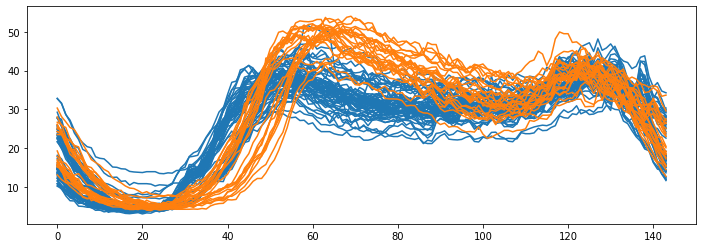

In [202]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
df_ = df.groupby([df.index.month, df.index.weekday]).mean()
X = df_.values
y = df_.reset_index([1])['date'].map(lambda x: 0 if x < 5 else 1).values
N = len(y)

print(X.shape, y.shape)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X[y == 0, :].T, '#1F77B4')
plt.plot(X[y == 1, :].T, '#FF7F0E')
plt.show()

In [203]:
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65*N):].copy()
train_indices = shuffled_indices_[:int(0.65*N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54, 144) (54,)
(30, 144) (30,)


### k-means

In [204]:
t = time()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

print(time() - t)

0.03944826126098633


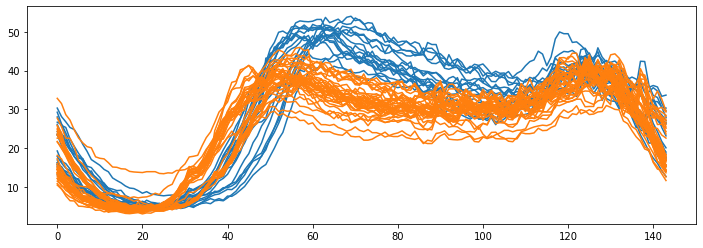

In [205]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [206]:
accuracy(labels, y_train)

0.9259259259259259

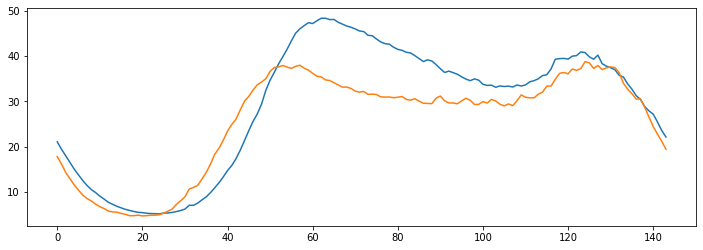

In [207]:
plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(kmeans.cluster_centers_[0, :].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1, :].T, '#FF7F0E')
plt.show()

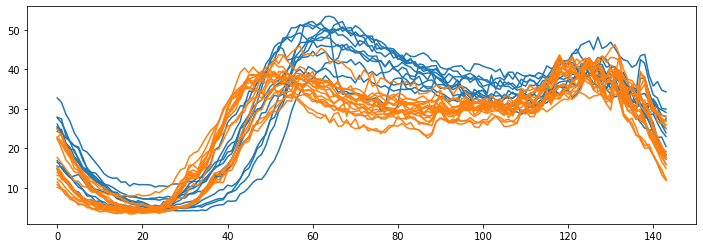

In [208]:
labels = kmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [209]:
accuracy(labels, y_test)

0.8333333333333334

### DBA-k-means

In [210]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=2, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

27.301377296447754


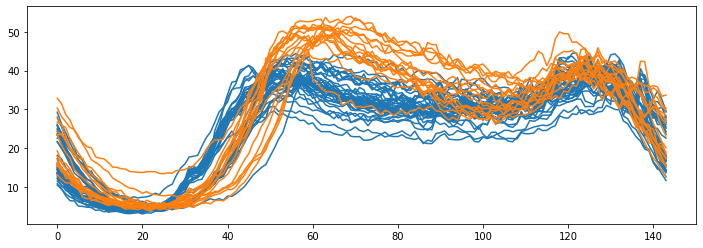

In [214]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [215]:
accuracy(labels, y_train)

0.9074074074074074

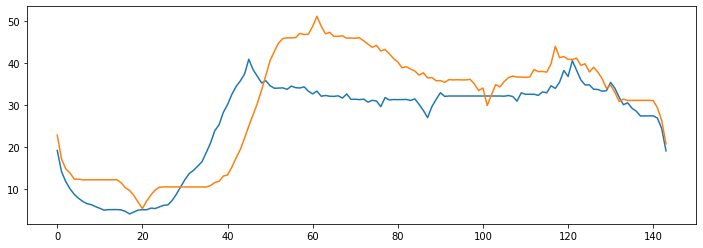

In [225]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0, :], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1, :], '#FF7F0E')
plt.show()

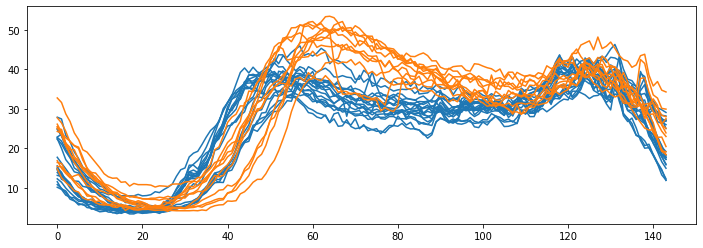

In [226]:
labels = tskmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [227]:
accuracy(labels, y_test)

0.8666666666666667

## b)

(651, 144) (651,)


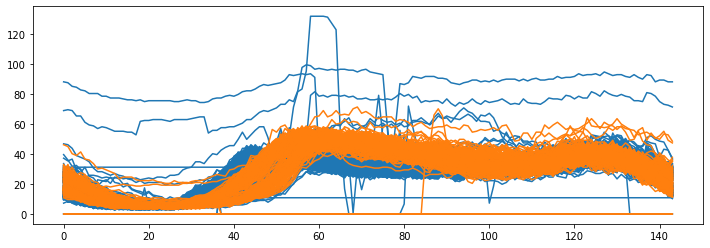

In [228]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
X = df.values
y = df.reset_index([0])['date'].map(lambda x: 0 if x.weekday() < 5 else 1).values
N = len(y)

print(X.shape, y.shape)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X[y == 0, :].T, '#1F77B4')
plt.plot(X[y == 1, :].T, '#FF7F0E')
plt.show()

In [229]:
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65*N):].copy()
train_indices = shuffled_indices_[:int(0.65*N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(423, 144) (423,)
(228, 144) (228,)


### k-means

In [230]:
t = time()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

print(time() - t)

0.07315230369567871


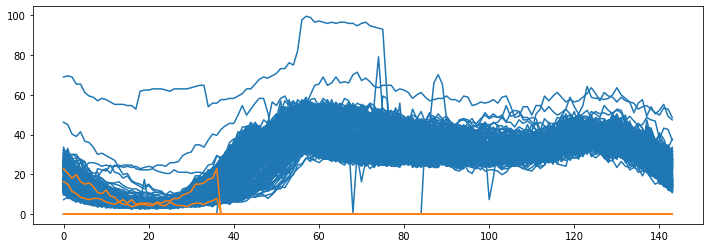

In [231]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [232]:
accuracy(labels, y_train)

0.6997635933806147

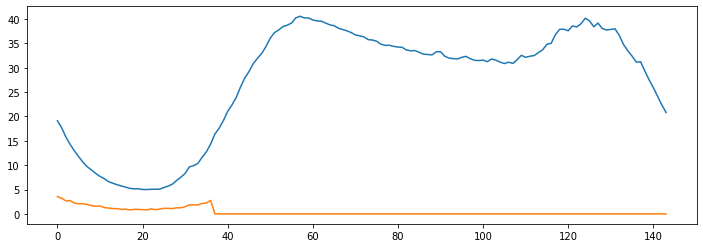

In [233]:
plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(kmeans.cluster_centers_[0, :].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1, :].T, '#FF7F0E')
plt.show()

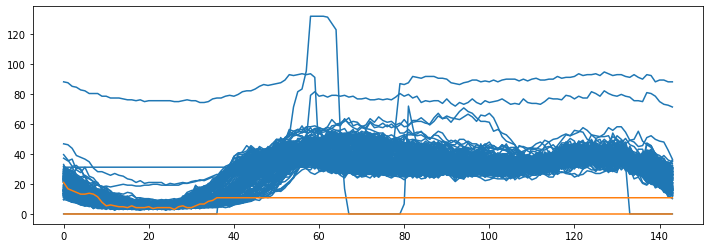

In [234]:
labels = kmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [235]:
accuracy(labels, y_test)

0.7105263157894737

### DBA-k-means

In [236]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=2, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

268.0636656284332


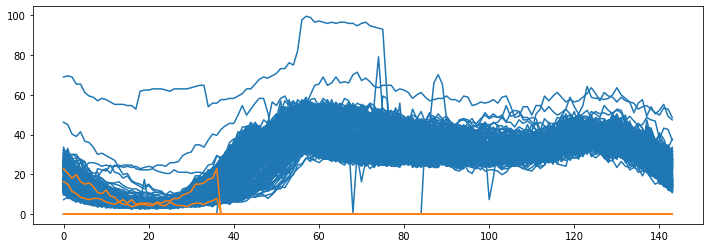

In [237]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [238]:
accuracy(labels, y_train)

0.6997635933806147

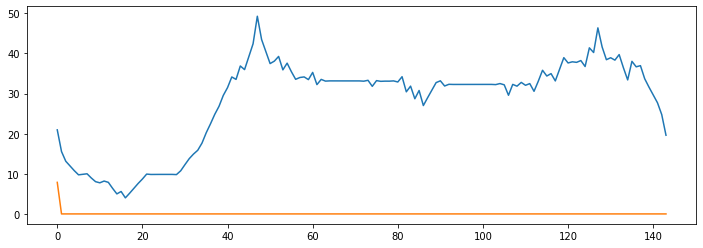

In [239]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0, :], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1, :], '#FF7F0E')
plt.show()

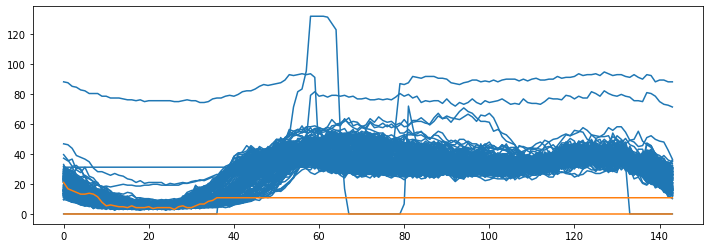

In [240]:
labels = tskmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [241]:
accuracy(labels, y_test)

0.7105263157894737

## c)

### aggregation

(84, 144) (84,)


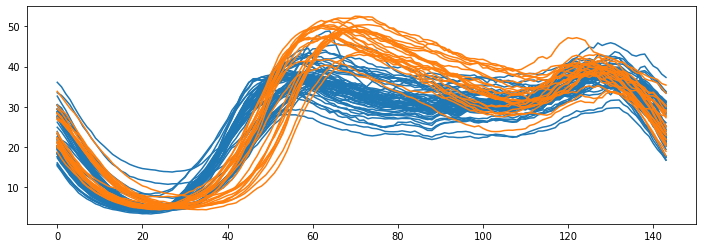

In [243]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
df_ = df.groupby([df.index.month, df.index.weekday]).mean()
X = df_.values
y = df_.reset_index([1])['date'].map(lambda x: 0 if x < 5 else 1).values
N = len(y)

X = X.reshape(-1)
prev_vals = 2
for t in range(len(X)):
    X[t] = X[max(0, t-prev_vals): t+1].mean()
X = X.reshape(-1, 144)

print(X.shape, y.shape)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X[y == 0, :].T, '#1F77B4')
plt.plot(X[y == 1, :].T, '#FF7F0E')
plt.show()

In [244]:
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65*N):].copy()
train_indices = shuffled_indices_[:int(0.65*N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54, 144) (54,)
(30, 144) (30,)


#### k-means

In [245]:
t = time()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

print(time() - t)

0.029307842254638672


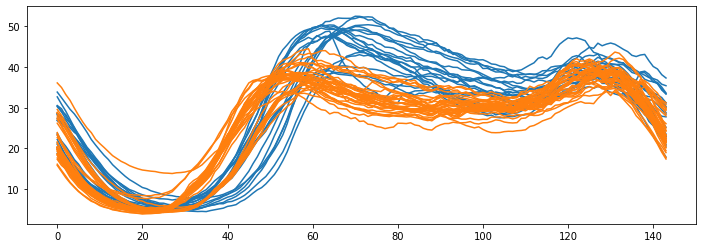

In [246]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [247]:
accuracy(labels, y_train)

0.8888888888888888

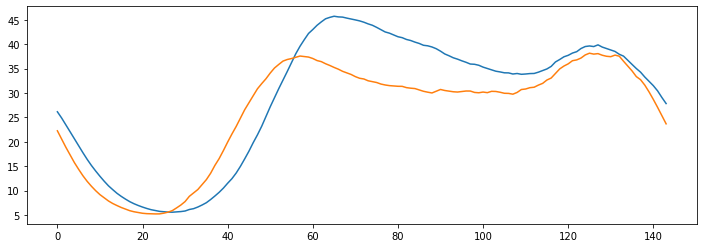

In [248]:
plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(kmeans.cluster_centers_[0, :].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1, :].T, '#FF7F0E')
plt.show()

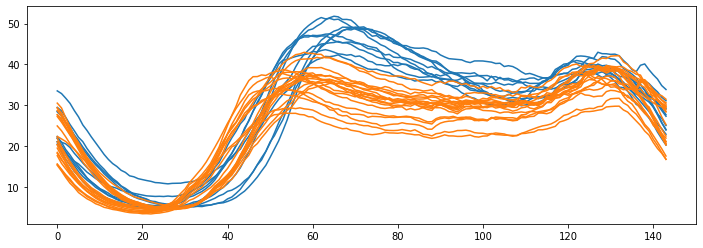

In [249]:
labels = kmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [250]:
accuracy(labels, y_test)

0.8666666666666667

#### DBA-k-means

In [251]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=2, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

26.139626264572144


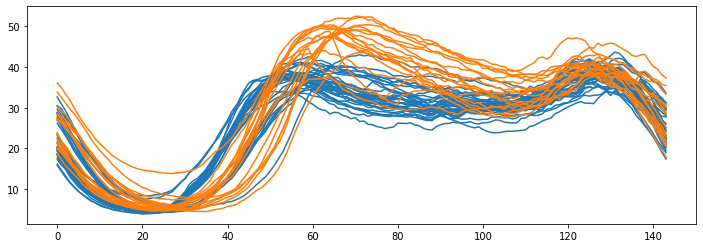

In [252]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [253]:
accuracy(labels, y_train)

0.8888888888888888

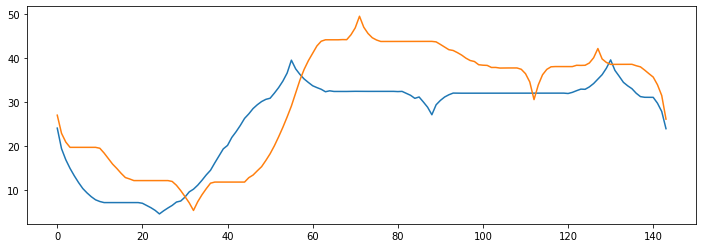

In [254]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0, :], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1, :], '#FF7F0E')
plt.show()

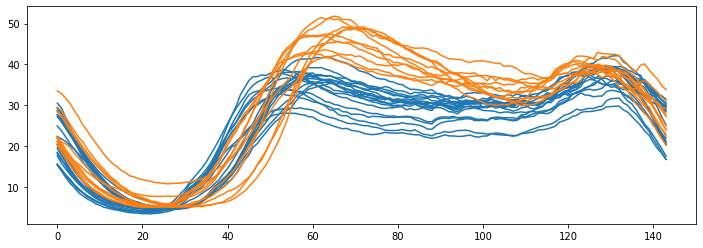

In [255]:
labels = tskmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [256]:
accuracy(labels, y_test)

0.8333333333333334

### no aggregation

Smoothening didn't really help

(651, 144) (651,)


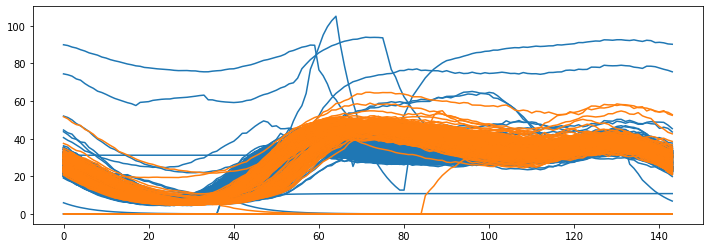

In [257]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
X = df.values
y = df.reset_index([0])['date'].map(lambda x: 0 if x.weekday() < 5 else 1).values
N = len(y)

X = X.reshape(-1)
prev_vals = 3
for t in range(len(X)):
    X[t] = X[max(0, t-prev_vals): t+1].mean()
X = X.reshape(-1, 144)

print(X.shape, y.shape)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X[y == 0, :].T, '#1F77B4')
plt.plot(X[y == 1, :].T, '#FF7F0E')
plt.show()

In [258]:
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65*N):].copy()
train_indices = shuffled_indices_[:int(0.65*N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(423, 144) (423,)
(228, 144) (228,)


#### k-means

In [259]:
t = time()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

print(time() - t)

0.07173633575439453


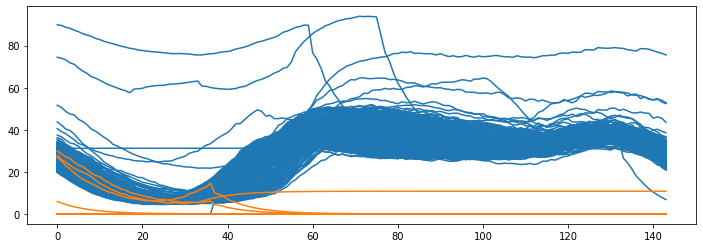

In [260]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0, :].T, '#1F77B4')
plt.plot(X_train[labels == 1, :].T, '#FF7F0E')
plt.show()

In [261]:
accuracy(labels, y_train)

0.6973995271867612

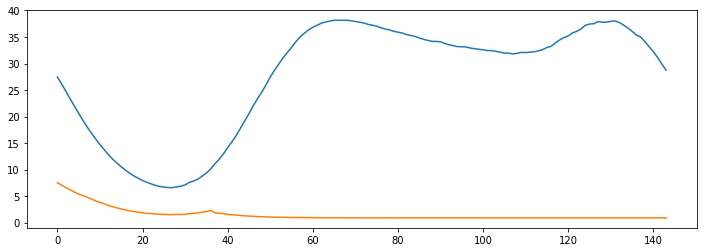

In [262]:
plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(kmeans.cluster_centers_[0, :].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1, :].T, '#FF7F0E')
plt.show()

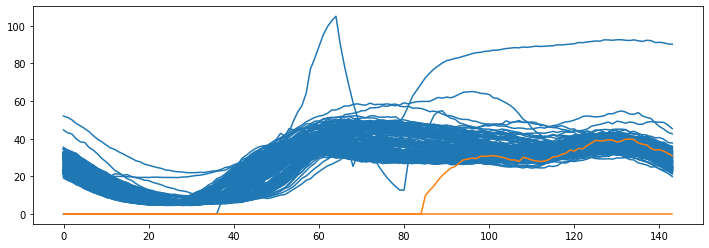

In [263]:
labels = kmeans.predict(X_test)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_test[labels == 0, :].T, '#1F77B4')
plt.plot(X_test[labels == 1, :].T, '#FF7F0E')
plt.show()

In [264]:
accuracy(labels, y_test)

0.7192982456140351

## d)

### ArrowHead

In [266]:
df = pd.read_csv('ArrowHead_TRAIN.txt', delimiter='  ', header=None)

#### No preprocessing

(36, 251) (36,)


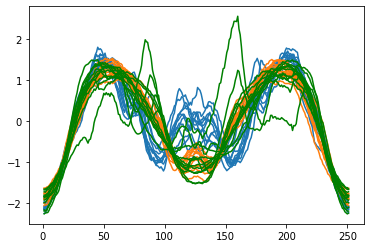

In [285]:
X_train = df.iloc[:, 1:]
Y_train = df.iloc[:, 0]

print(X_train.shape, Y_train.shape)
plt.plot(X_train[Y_train==0].T, '#1F77B4')
plt.plot(X_train[Y_train==1].T, '#FF7F0E')
plt.plot(X_train[Y_train==2].T, 'g')
plt.show()

##### k-means

In [268]:
t = time()

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

print(time() - t)

0.036879777908325195


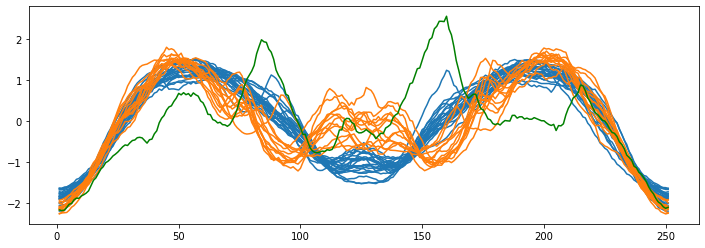

In [269]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.show()

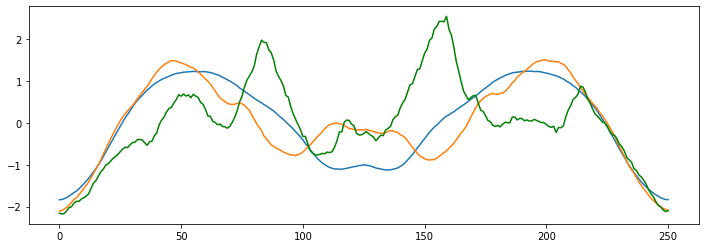

In [271]:
plt.figure(figsize=(12, 4))
plt.plot(kmeans.cluster_centers_[0].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1].T, '#FF7F0E')
plt.plot(kmeans.cluster_centers_[2].T, 'g')
plt.show()

##### k-means, 4 clusters

In [286]:
t = time()

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train)

print(time() - t)

0.033205509185791016


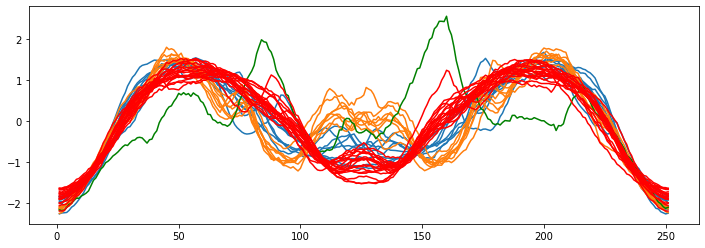

In [288]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.plot(X_train[labels == 3].T, 'r')
plt.show()

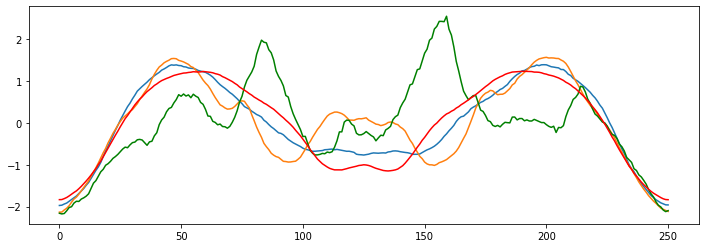

In [289]:
plt.figure(figsize=(12, 4))
plt.plot(kmeans.cluster_centers_[0].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1].T, '#FF7F0E')
plt.plot(kmeans.cluster_centers_[2].T, 'g')
plt.plot(kmeans.cluster_centers_[3].T, 'r')
plt.show()

##### DBA-k-means

In [272]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=3, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

31.388227224349976


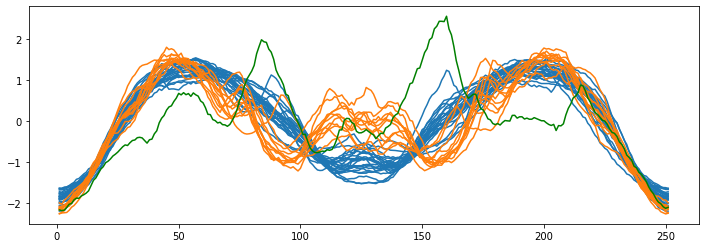

In [275]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.show()

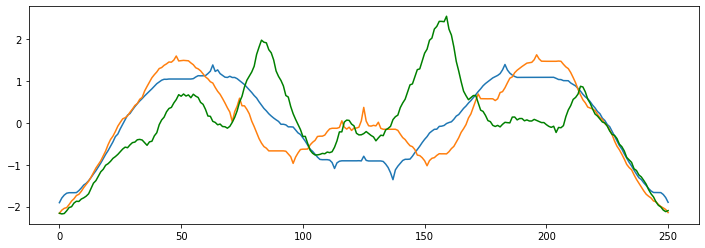

In [276]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1], '#FF7F0E')
plt.plot(tskmeans.cluster_centers_[2], 'g')
plt.show()

##### DBA-k-means, 4 clusters

In [293]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

37.70918011665344


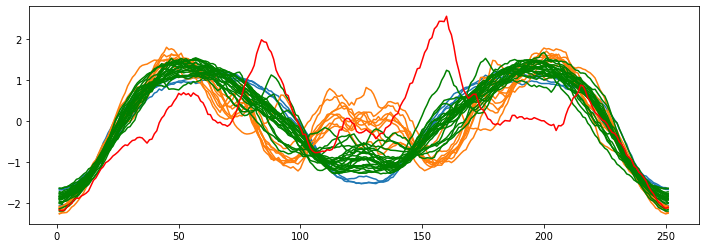

In [294]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.plot(X_train[labels == 3].T, 'r')
plt.show()

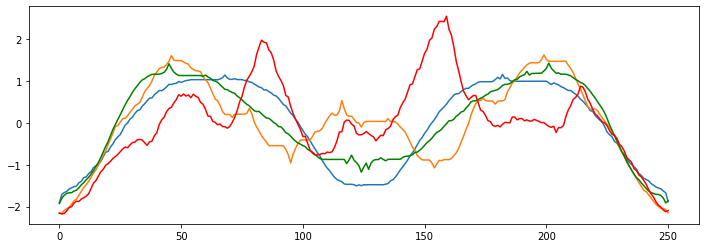

In [296]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1], '#FF7F0E')
plt.plot(tskmeans.cluster_centers_[2], 'g')
plt.plot(tskmeans.cluster_centers_[3], 'r')
plt.show()

#### Smoothening

(36, 249) (36,)


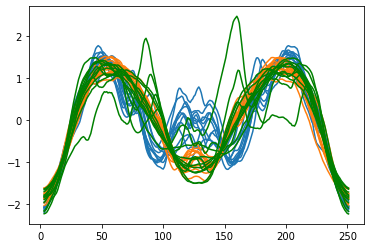

In [278]:
prev_vals = 3

X_train = df.iloc[:, 1:]
X_train = X_train.rolling(prev_vals, axis=1).mean().dropna(axis=1)

Y_train = df.iloc[:, 0]

print(X_train.shape, Y_train.shape)
plt.plot(X_train[Y_train==0].T, '#1F77B4')
plt.plot(X_train[Y_train==1].T, '#FF7F0E')
plt.plot(X_train[Y_train==2].T, 'g')
plt.show()

##### k-means

In [279]:
t = time()

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

print(time() - t)

0.03310346603393555


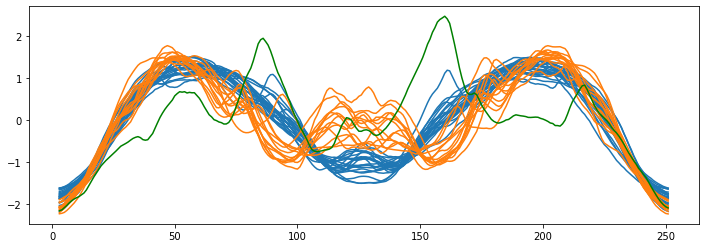

In [280]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.show()

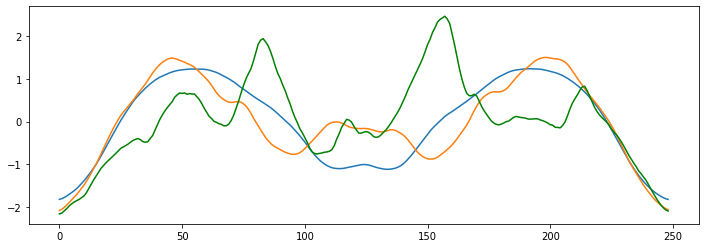

In [281]:
plt.figure(figsize=(12, 4))
plt.plot(kmeans.cluster_centers_[0].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1].T, '#FF7F0E')
plt.plot(kmeans.cluster_centers_[2].T, 'g')
plt.show()

##### DBA-k-means

In [282]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=3, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

35.41881513595581


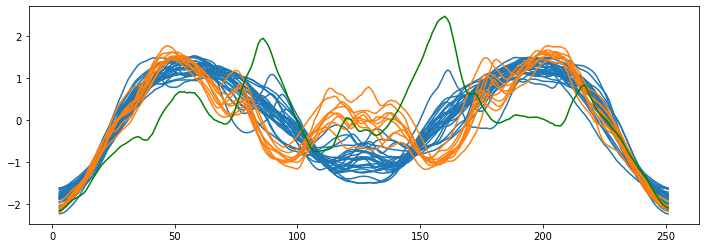

In [283]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.show()

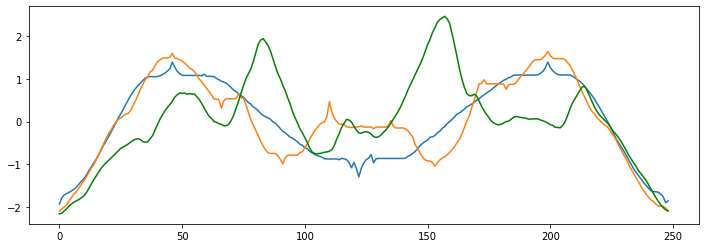

In [284]:
plt.figure(figsize=(12, 4))
plt.plot(tskmeans.cluster_centers_[0], '#1F77B4')
plt.plot(tskmeans.cluster_centers_[1], '#FF7F0E')
plt.plot(tskmeans.cluster_centers_[2], 'g')
plt.show()

### Basic Motion

In [298]:
!pip install pyts

     |████████████████████████████████| 2.5MB 6.0MB/s 


In [384]:
from pyts.datasets import load_basic_motions
bunch = load_basic_motions()
bunch.data_train.shape
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)
X_test.shape

X = np.vstack((X_train, X_test))
Y = np.hstack((y_train, y_test))

In [385]:
np.unique(Y)

array([b'Badminton', b'Running', b'Standing', b'Walking'], dtype='|S12')

(80, 6, 100) (80,)


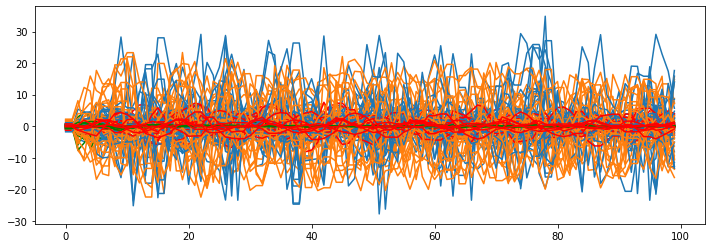

In [386]:
print(X.shape, Y.shape)
plt.figure(figsize=(12,4))
for i in range(6):
    plt.plot(X[Y==b'Badminton'][i].T, '#1F77B4')
    plt.plot(X[Y==b'Running'][i].T, '#FF7F0E')
    plt.plot(X[Y==b'Standing'][i].T, 'g')
    plt.plot(X[Y==b'Walking'][i].T, 'r')
plt.show()

In [387]:
X = X.reshape(-1, 100)

In [388]:
np.random.shuffle(X)

#### No preprocessing

In [389]:
X.shape

(480, 100)

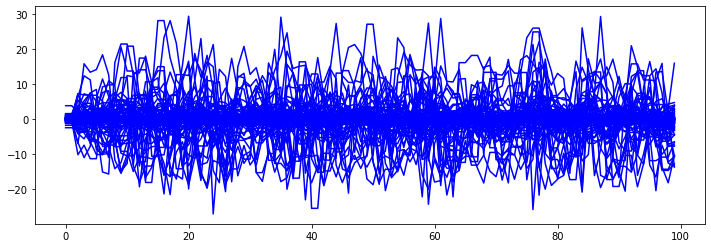

In [390]:
plt.figure(figsize=(12,4))
plt.plot(X[:100].T, 'b')
pass

In [391]:
X_train = X[:400]
X_test = X[400:]

##### k-means

In [397]:
t = time()

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train)

print(time() - t)

0.12279009819030762


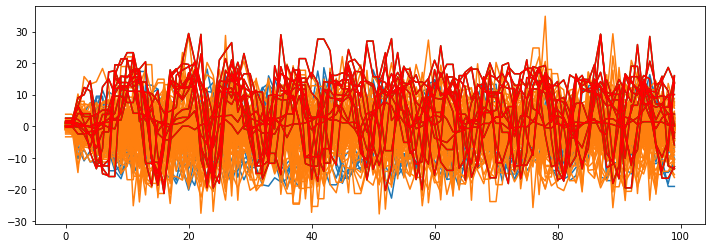

In [398]:
labels = kmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.plot(X_train[labels == 2].T, 'r')
plt.show()

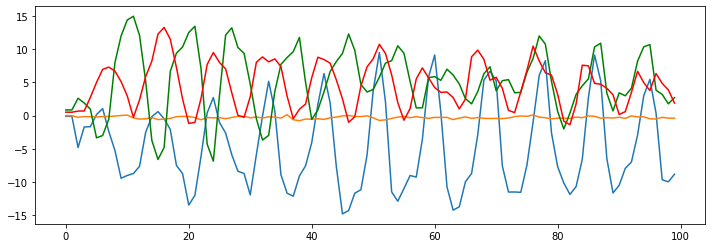

In [399]:
plt.figure(figsize=(12, 4))
plt.plot(kmeans.cluster_centers_[0].T, '#1F77B4')
plt.plot(kmeans.cluster_centers_[1].T, '#FF7F0E')
plt.plot(kmeans.cluster_centers_[2].T, 'g')
plt.plot(kmeans.cluster_centers_[3].T, 'r')
plt.show()

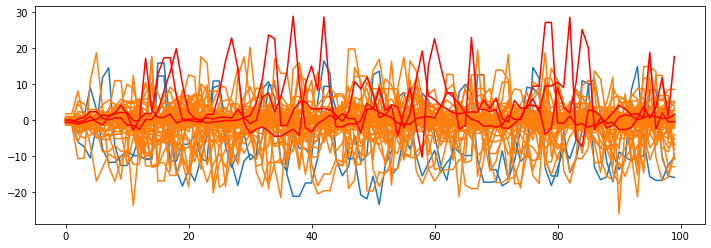

In [404]:
labels = kmeans.predict(X_test)

plt.figure(figsize=(12, 4))
for label, color in zip(range(4), ['#1F77B4', '#FF7F0E', 'g', 'r']):
    if np.any(labels == label) :
        plt.plot(X_test[labels == label].T, color)
plt.show()

##### DBA-k-means

In [405]:
t = time()

tskmeans = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter_barycenter=100, n_init=5)
tskmeans.fit(X_train)

print(time() - t)

185.68661665916443


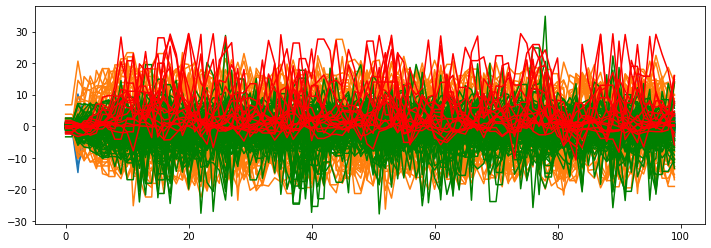

In [406]:
labels = tskmeans.predict(X_train)

plt.figure(figsize=(12, 4))
# plt.plot(X.T, 'k')
plt.plot(X_train[labels == 0].T, '#1F77B4')
plt.plot(X_train[labels == 1].T, '#FF7F0E')
plt.plot(X_train[labels == 2].T, 'g')
plt.plot(X_train[labels == 3].T, 'r')
plt.show()

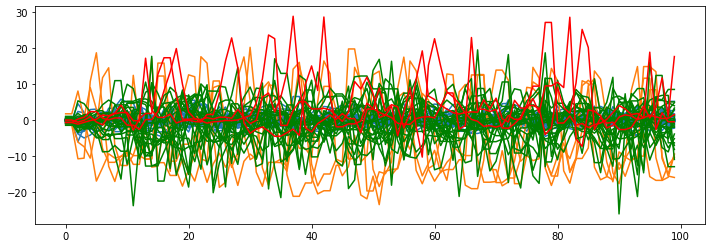

In [410]:
labels = tskmeans.predict(X_test)

plt.figure(figsize=(12, 4))
for label, color in zip(range(4), ['#1F77B4', '#FF7F0E', 'g', 'r']):
    if np.any(labels == label) :
        plt.plot(X_test[labels == label].T, color)
plt.show()